In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [8]:

fn_src = 'https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1'
fn_dst = 'example_data_s1.pickle'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    urllib.request.urlretrieve(fn_src, fn_dst)

File example_data_s1.pickle is already downloaded


In [9]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

In [10]:
tsamp = 0.05
# TODO
nt = len(X[:,0])
print("nt = " + str(nt))
nneuron = len(X[0,:])
print("nneuron = " + str(nneuron))
nout = len(y[:,0])
print("nout = " + str(nout))
ttotal = nt * 0.05
print("ttotal = " + str(ttotal))

nt = 61339
nneuron = 52
nout = 61339
ttotal = 3066.9500000000003


Fitting a Memoryless Linear Model

In [38]:
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.33)

In [39]:
reg = LinearRegression().fit(Xtr, ytr)
yhat = reg.predict(Xts)
from sklearn.metrics import r2_score
rsq = r2_score(yts, yhat)
print(rsq)

0.46296291885593216


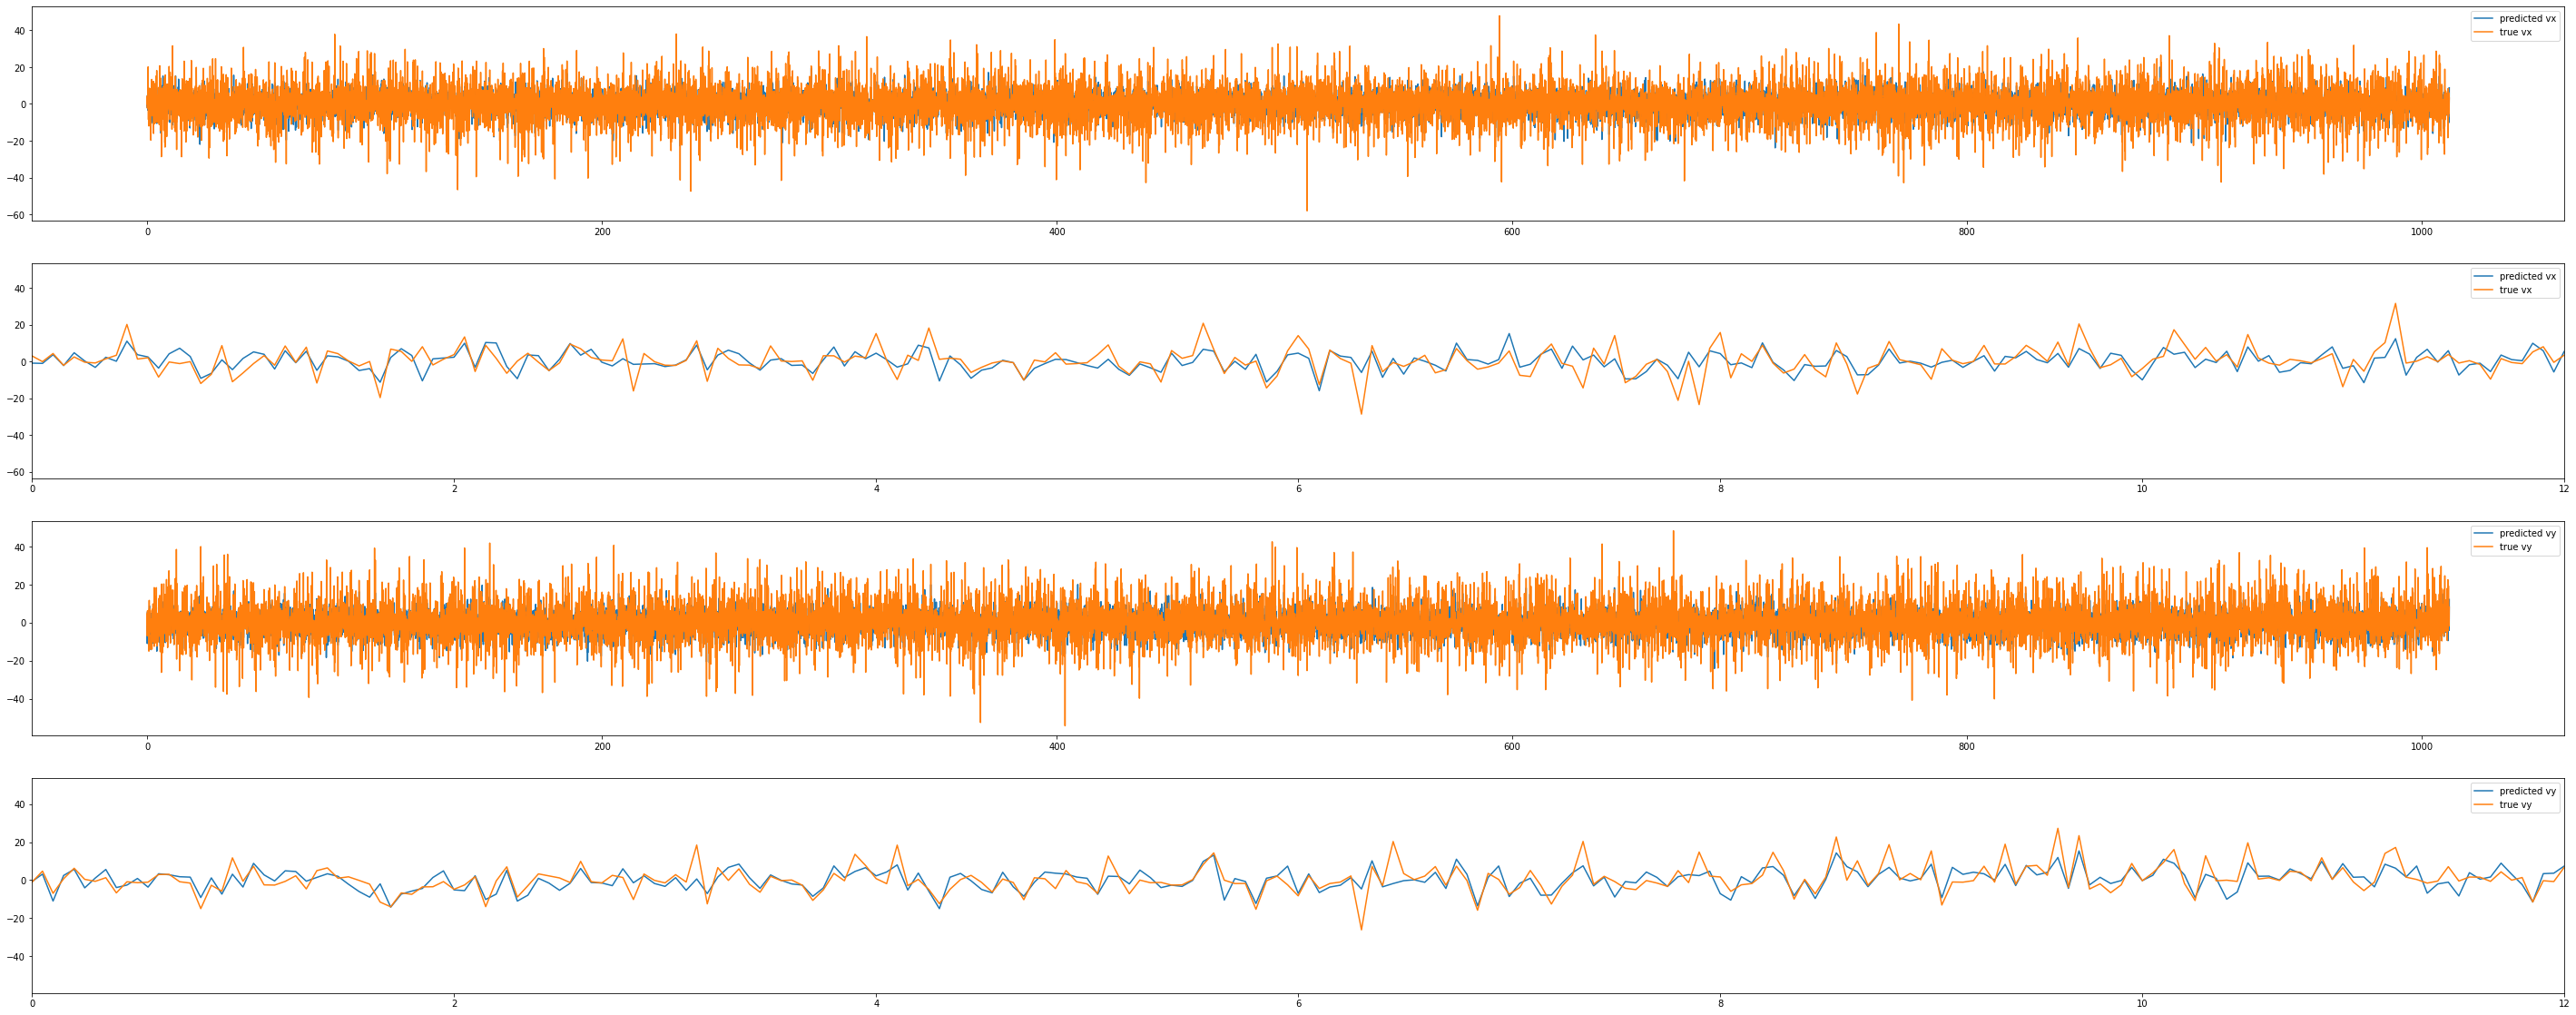

In [44]:
t = np.arange(0, 20242 * tsamp, tsamp)
plt.figure(figsize=(50,20))
plt.subplot(4,1,1)
plt.plot(t, yhat[:,0], label='predicted vx')
plt.plot(t, yts[:,0], label='true vx')
plt.legend()
plt.subplot(4,1,2)
plt.plot(t, yhat[:,0], label='predicted vx')
plt.plot(t, yts[:,0], label='true vx')
plt.xlim((0,12))
plt.legend()
plt.subplot(4,1,3)
plt.plot(t, yhat[:,1], label='predicted vy')
plt.plot(t, yts[:,1], label='true vy')
plt.legend()
plt.subplot(4,1,4)
plt.plot(t, yhat[:,1], label='predicted vy')
plt.plot(t, yts[:,1], label='true vy')
plt.xlim((0,12))
plt.legend()
plt.show()

Fitting Models with Delay

In [27]:
def create_dly_data(X,y,dly):
    """
    Create delayed data
    """    
    # TODO
    Xtmp = X.copy()
    Xdly = X
    extra_row = len(X[:,0])
    for i in range(dly):
        Xtmp = np.insert(Xtmp,0,0,axis = 0)
        Xtmp = np.delete(Xtmp,extra_row,0)
        np.concatenate((Xdly, Xtmp), axis=1)
    return Xdly, y
Xred = X[:6000,:]
yred = y[:6000,:]
xt, yt = create_dly_data(Xred,yred,6)

In [28]:
Xtr, Xts, ytr, yts = train_test_split(xt, yt, test_size=0.33)
reg = LinearRegression().fit(Xtr, ytr)
yhat = reg.predict(Xts)
rsq = r2_score(yts, yhat)
print(rsq)

0.45673382406814406


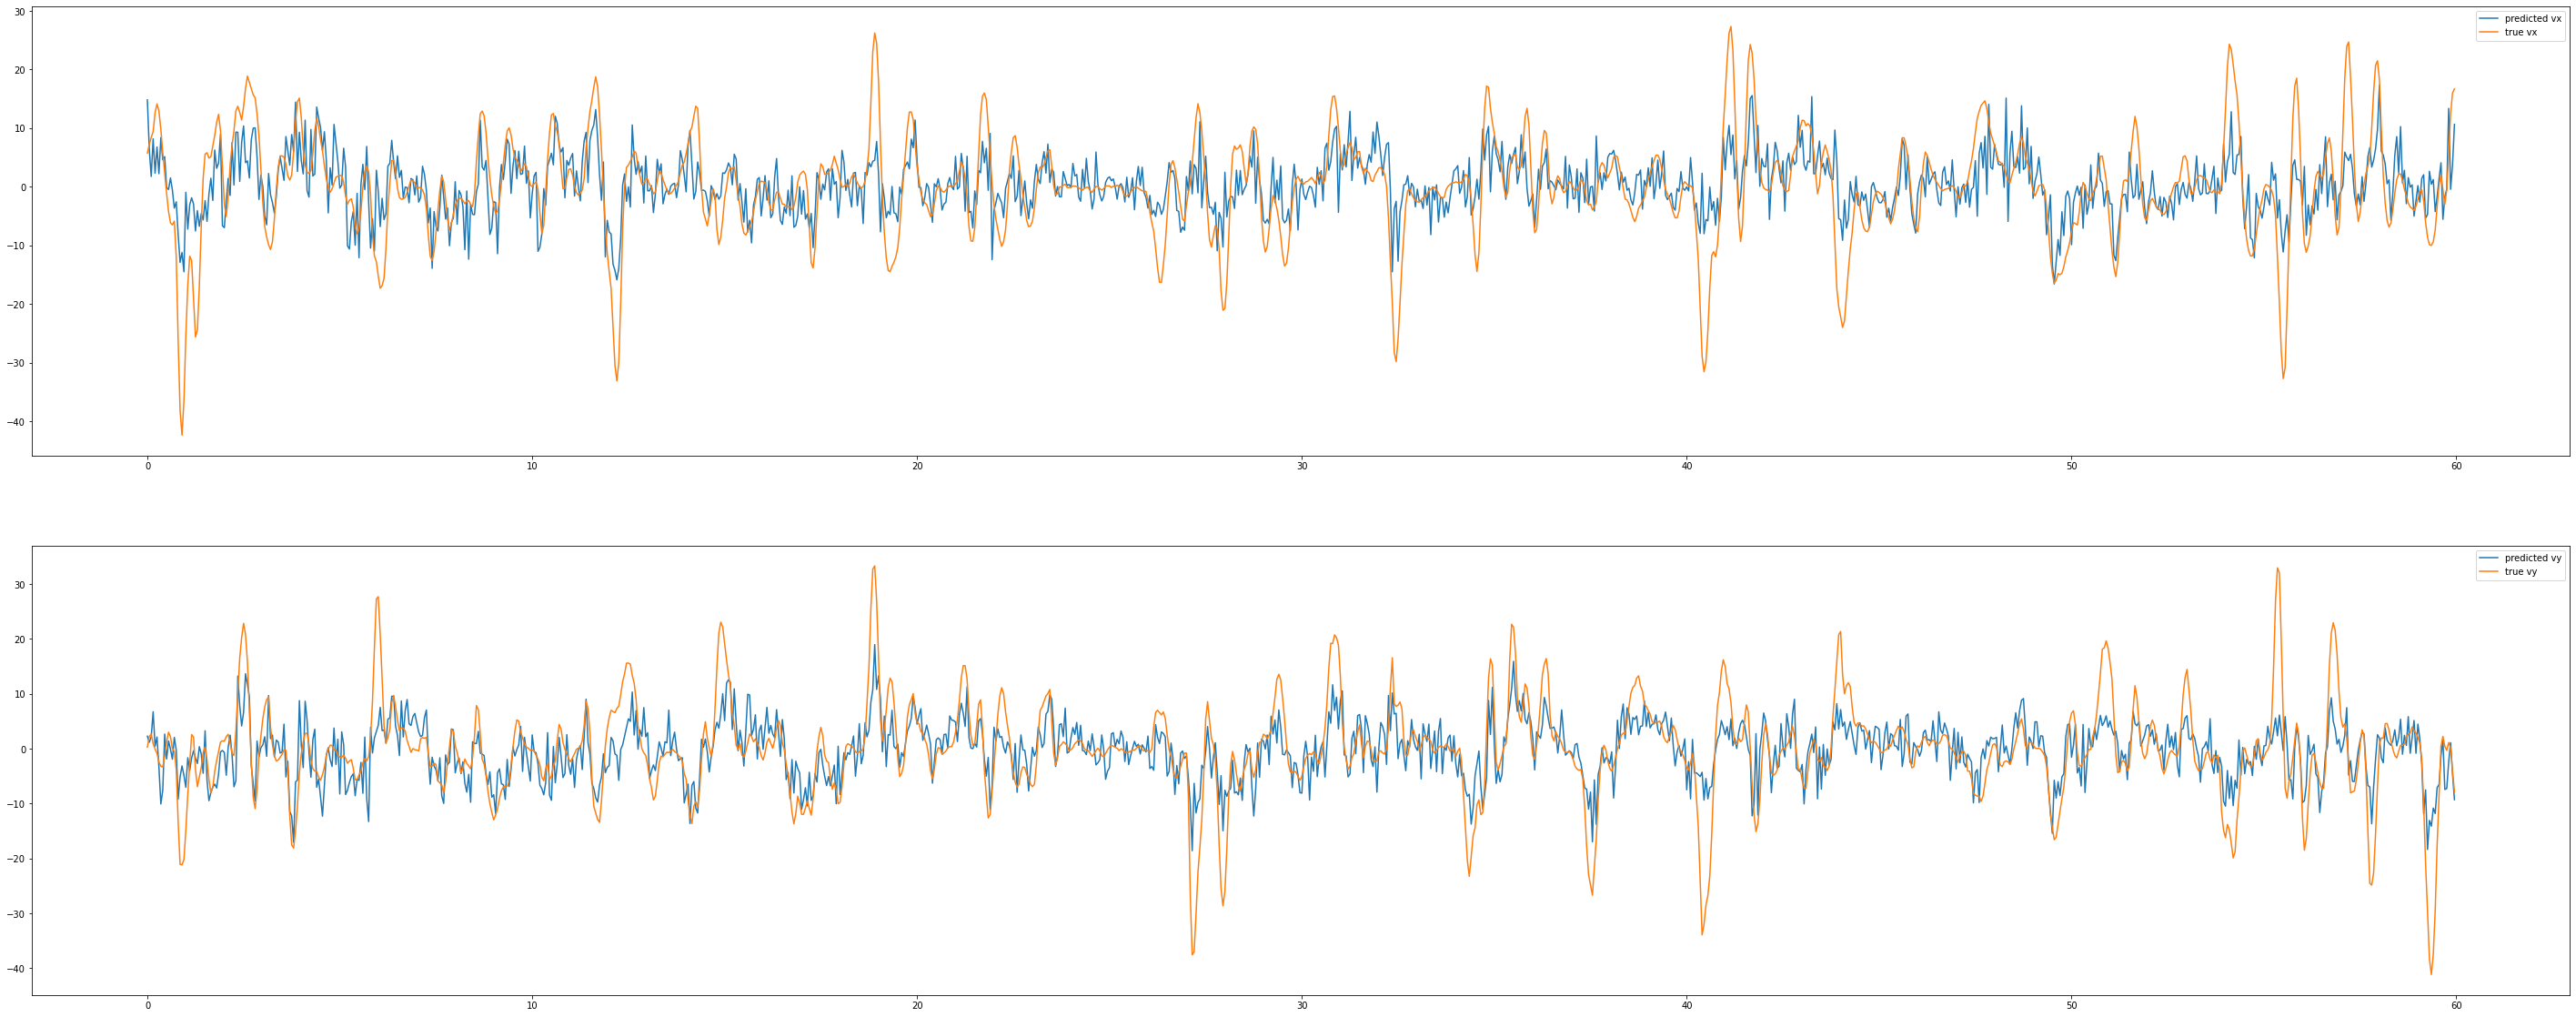

In [35]:
t = np.arange(0, len(yhat[:,0]) / 20, tsamp)
plt.figure(figsize=(50,20))
plt.subplot(2,1,1)
plt.plot(t, yhat[:,0], label='predicted vx')
plt.plot(t, yts[:,0], label='true vx')
plt.legend()
plt.subplot(2,1,2)
plt.plot(t, yhat[:,1], label='predicted vy')
plt.plot(t, yts[:,1], label='true vy')
plt.legend()
plt.show()

Selecting the Optimal Delay via Model Order Selection

In [29]:
nred = 6000
Xred = X[:nred,:]
yred = y[:nred,:]

In [31]:
import  sklearn.model_selection 
import tqdm.notebook

def create_dly_data(X,y,dly):
    """
    Create delayed data
    """    
    # TODO
    Xtmp = X.copy()
    Xdly = X
    extra_row = len(X[:,0])
    for i in range(dly):
        Xtmp = np.insert(Xtmp,0,0,axis = 0)
        Xtmp = np.delete(Xtmp,extra_row,0)
        np.concatenate((Xdly, Xtmp), axis=1)
    return Xdly, y

nfold = 5  # Number of folds
dmax = 15  # maximum number of delays

# TODO:  Create a k-fold object
kf = sklearn.model_selection.KFold(n_splits=nfold, random_state=None, shuffle=False)

# TODO:  Model orders to be tested
dtest = np.arange(dmax + 1)
nd = len(dtest)

# TODO.  
# Initialize a matrix Rsq to hold values of the R^2 across the model orders and folds.
# Alternatively, you can also create an RSS matrix
rsq = np.zeros(nd * nfold).reshape(nd, nfold)

# Create a progress bar.  Note there are nd*nfold total fits.
pbar = tqdm.notebook.tqdm(
    total=nfold*nd, initial=0,
    unit='fits', unit_divisor=nd, desc='Model order test')


for it, d in enumerate(dtest):
    # TODO:  
    # Create the delayed data using the create_dly_function from the reduced
    # data Xred, yred
    Xdly, ydly = create_dly_data(Xred, yred, d)    
    
        
    # Loop over the folds
    for isplit, Ind in enumerate(kf.split(Xdly)):

        # Get the training data in the split
        Itr, Its = Ind        

        # TODO
        # Split the data (Xdly,ydly) into training and test
        Xtr = Xdly[Itr,:]
        ytr = ydly[Itr,:]
        Xts = Xdly[Its,:]
        yts = ydly[Its,:]
        
        # TODO:  Fit data on training data        
        reg = LinearRegression().fit(Xtr, ytr)
        # TODO:  Measure the R^2 vale on test data and store in the matrix Rsq
        yhat = reg.predict(Xts)
        rsq_cur = r2_score(yts, yhat)
        rsq[it, isplit] = rsq_cur
        pbar.update(1)
print(rsq)
pbar.close()

[[0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]]

